In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [90]:
df = pd.read_csv('selected_data.csv')

In [91]:
print("Data shape:", df.shape)
print(df.info())

Data shape: (21887, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21887 entries, 0 to 21886
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symbol             21887 non-null  object 
 1   date               21887 non-null  object 
 2   open               21887 non-null  float64
 3   high               21887 non-null  float64
 4   low                21887 non-null  float64
 5   close              21887 non-null  float64
 6   close_adjusted     21887 non-null  float64
 7   volume             21887 non-null  int64  
 8   split_coefficient  21887 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.5+ MB
None


In [92]:
print(df.describe(include='all'))

       symbol        date          open          high           low  \
count   21887       21887  21887.000000  21887.000000  21887.000000   
unique     10        5899           NaN           NaN           NaN   
top      AABA  2021-04-21           NaN           NaN           NaN   
freq     5486           8           NaN           NaN           NaN   
mean      NaN         NaN     32.582640     33.202068     31.964162   
std       NaN         NaN     34.649756     35.713518     33.648852   
min       NaN         NaN      0.000000      0.000000      0.000000   
25%       NaN         NaN     10.380000     10.530000     10.210000   
50%       NaN         NaN     27.750000     28.230000     27.310000   
75%       NaN         NaN     41.455000     42.050000     40.905000   
max       NaN         NaN    464.500000    500.100000    442.000000   

               close  close_adjusted        volume  split_coefficient  
count   21887.000000    21887.000000  2.188700e+04       21887.000000  
uni

In [93]:
print("Missing values by column:")
print(df.isnull().sum())

Missing values by column:
symbol               0
date                 0
open                 0
high                 0
low                  0
close                0
close_adjusted       0
volume               0
split_coefficient    0
dtype: int64


In [94]:
print("Unique stock symbols:", df['symbol'].unique())
print(df['split_coefficient'].value_counts())

Unique stock symbols: ['A' 'AA' 'AAAP' 'AABA' 'AAC' 'AACG' 'AACQ' 'AACQU' 'AACQW' 'AAL']
split_coefficient
1.0    21883
2.0        4
Name: count, dtype: int64


In [95]:
numeric_cols = ['open', 'high', 'low', 'close', 'close_adjusted', 'volume']
for col in numeric_cols:
    print(f"{col}: {df[col].min()} min, {df[col].max()} max")
    print(f"Non-positive {col} values:", (df[col] <= 0).sum())

open: 0.0 min, 464.5 max
Non-positive open values: 17
high: 0.0 min, 500.1 max
Non-positive high values: 17
low: 0.0 min, 442.0 max
Non-positive low values: 17
close: 0.34 min, 475.0 max
Non-positive close values: 0
close_adjusted: 0.34 min, 138.13 max
Non-positive close_adjusted values: 0
volume: 0 min, 438248798 max
Non-positive volume values: 113


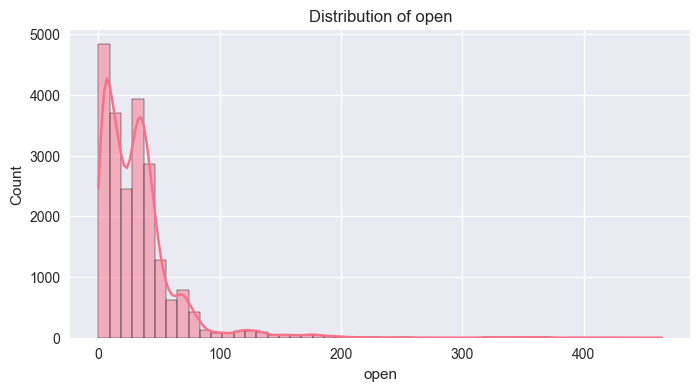

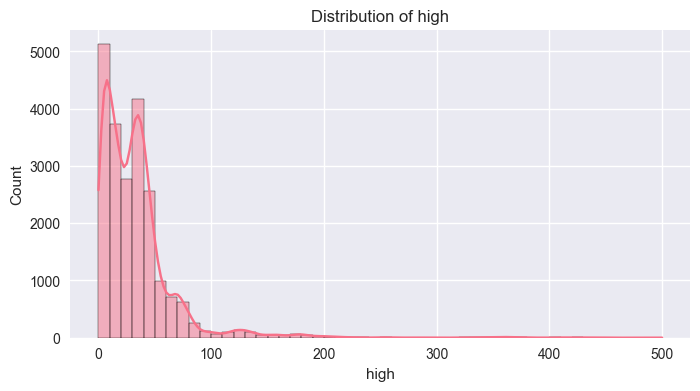

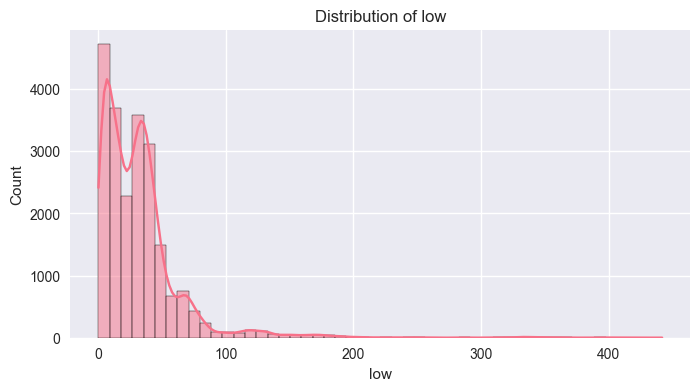

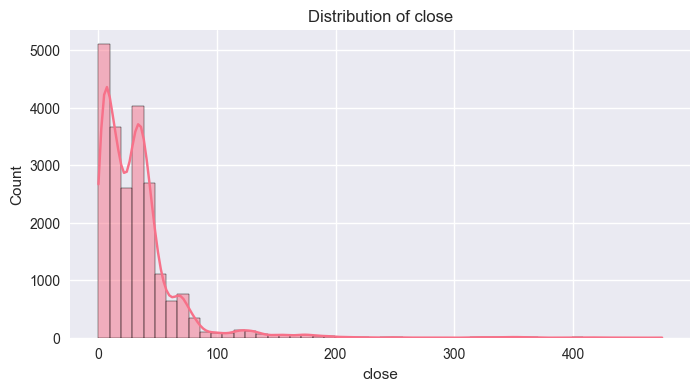

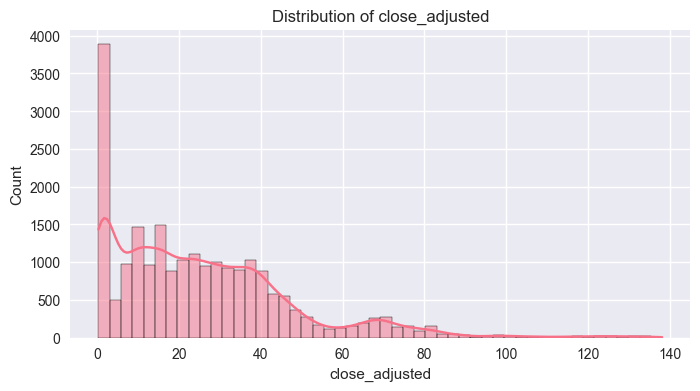

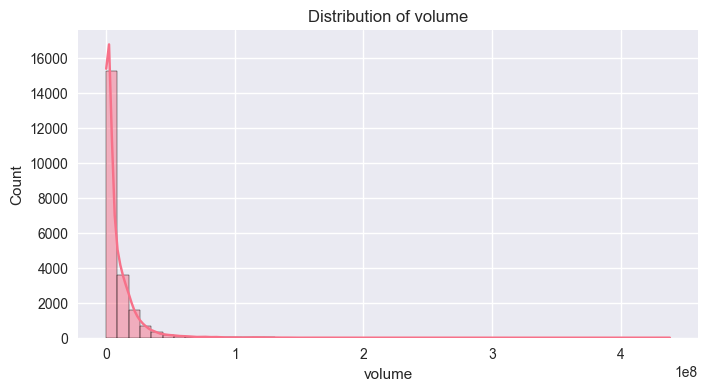

In [96]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

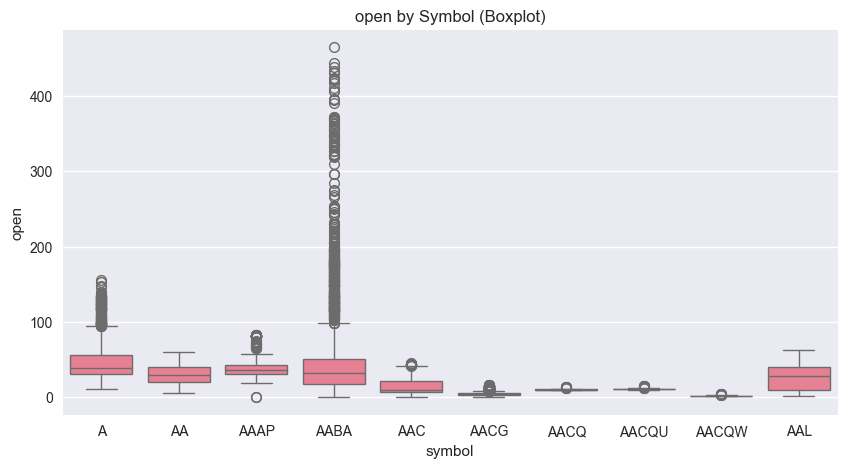

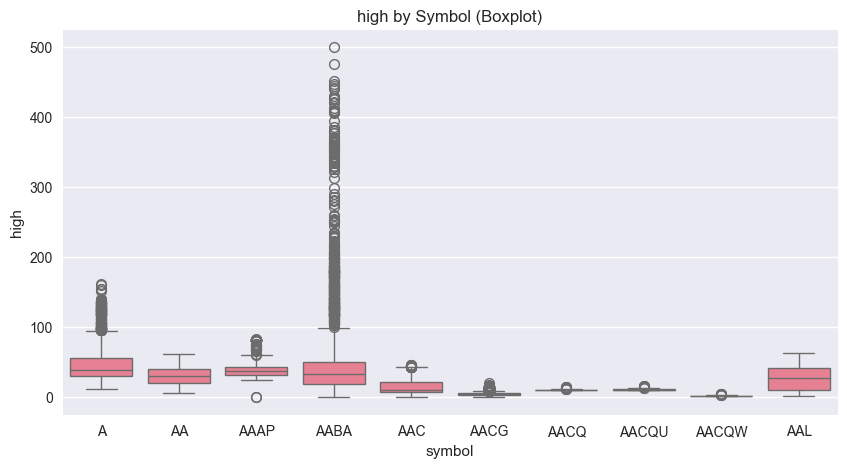

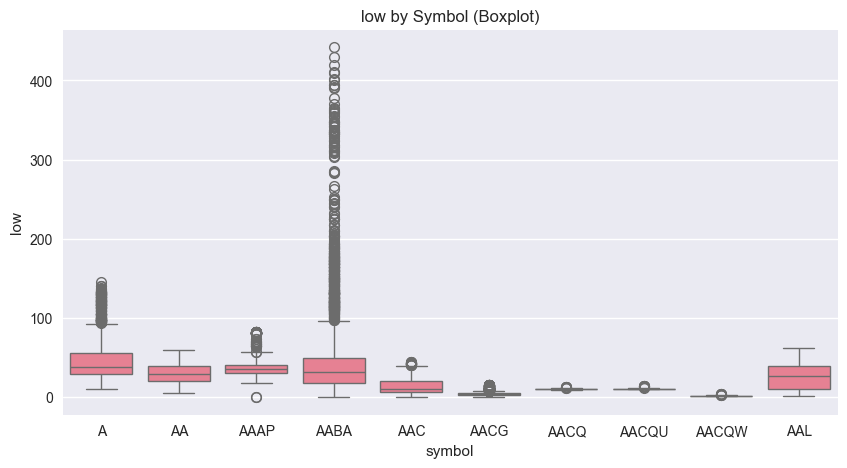

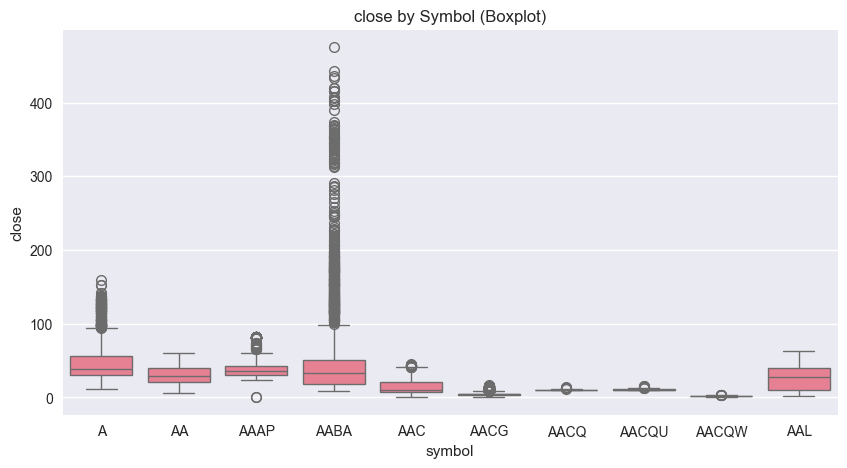

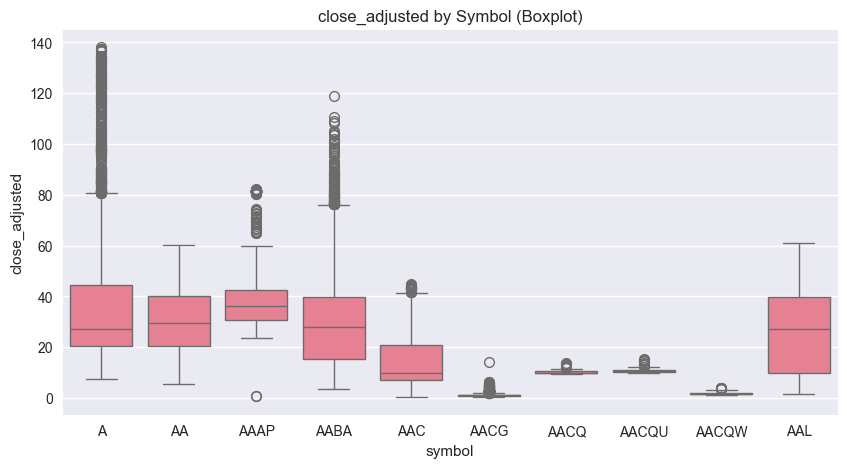

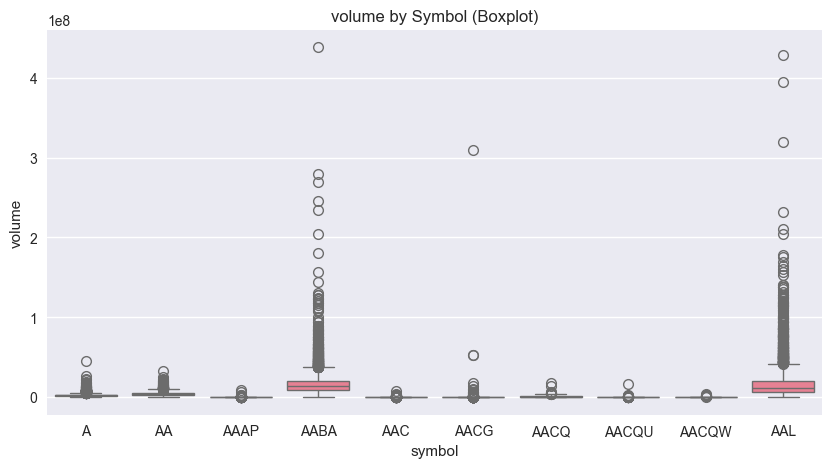

In [97]:
for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='symbol', y=col, data=df)
    plt.title(f"{col} by Symbol (Boxplot)")
    plt.show()

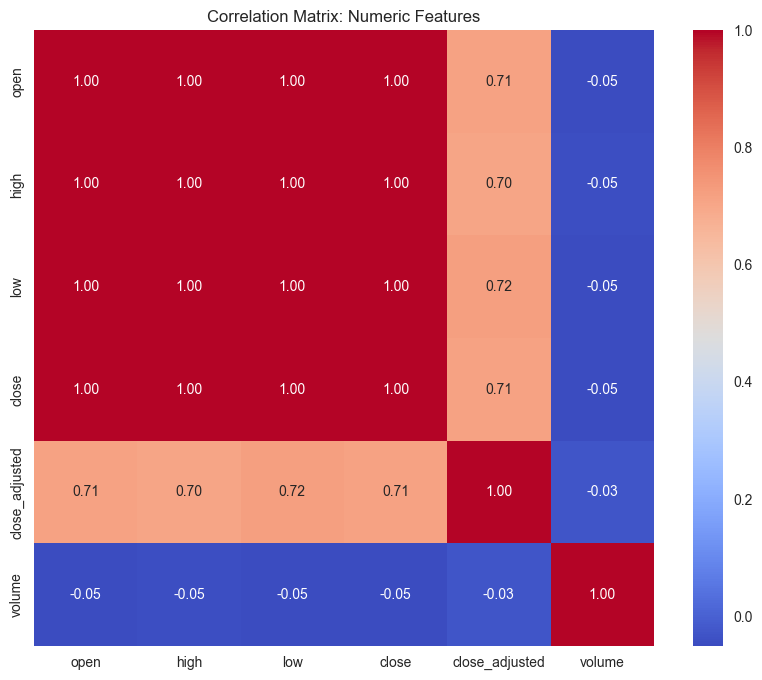

In [98]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix: Numeric Features")
plt.show()

In [99]:
# Droping rows where 'open', 'high', or 'low' are zero or negative (invalid price)
df_clean = df[(df['open'] > 0) & (df['high'] > 0) & (df['low'] > 0)]

# Droping rows where volume is zero (no trades)
df_clean = df_clean[df_clean['volume'] > 0]

In [100]:
# Intraday price spread
df_clean['spread'] = df_clean['high'] - df_clean['low']

# Open-close change (price movement during day)
df_clean['price_change'] = df_clean['close'] - df_clean['open']

# Percentage change between close and open (returns)
df_clean['pct_change'] = (df_clean['close'] - df_clean['open']) / df_clean['open']

# Ratios capturing relative price positions
df_clean['high_low_ratio'] = df_clean['high'] / df_clean['low']
df_clean['close_open_ratio'] = df_clean['close'] / df_clean['open']

# Log transform for volume due to high skew
df_clean['log_volume'] = np.log1p(df_clean['volume'])

# Binary flag for stock split events
df_clean['split_flag'] = df_clean['split_coefficient'].apply(lambda x: 1 if x > 1 else 0)

# Encode 'symbol' categorical variable as one-hot
df_clean = pd.get_dummies(df_clean, columns=['symbol'], drop_first=True)


In [101]:
df_clean

,date,open,high,low,close,close_adjusted,volume,split_coefficient,spread,price_change,...,split_flag,symbol_AA,symbol_AAAP,symbol_AABA,symbol_AAC,symbol_AACG,symbol_AACQ,symbol_AACQU,symbol_AACQW,symbol_AAL
0,1999-11-18,45.50,50.0000,40.00,44.00,29.6303,44739900,1.0,10.0000,-1.50,...,0,False,False,False,False,False,False,False,False,False
1,1999-11-19,42.94,43.0000,39.81,40.38,27.1926,10897100,1.0,3.1900,-2.56,...,0,False,False,False,False,False,False,False,False,False
2,1999-11-22,41.31,44.0000,40.06,44.00,29.6303,4705200,1.0,3.9400,2.69,...,0,False,False,False,False,False,False,False,False,False
3,1999-11-23,42.50,43.6300,40.25,40.25,27.1050,4274400,1.0,3.3800,-2.25,...,0,False,False,False,False,False,False,False,False,False
4,1999-11-24,40.13,41.9400,40.00,41.06,27.6505,3464400,1.0,1.9400,0.93,...,0,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21882,2021-06-07,24.49,24.7712,24.18,24.25,24.2500,21173236,1.0,0.5912,-0.24,...,0,False,False,False,False,False,False,False,False,True
21883,2021-06-08,24.42,24.4900,23.86,24.22,24.2200,26105566,1.0,0.6300,-0.20,...,0,False,False,False,False,False,False,False,False,True
21884,2021-06-09,24.37,24.4100,23.84,23.85,23.8500,20289048,1.0,0.5700,-0.52,...,0,False,False,False,False,False,False,False,False,True
21885,2021-06-10,24.14,24.2400,23.26,23.46,23.4600,28988336,1.0,0.9800,-0.68,...,0,False,False,False,False,False,False,False,False,True


In [102]:
# Drop 'open', 'high', 'low', keep only 'close_adjusted' as representative price feature
df_model = df_clean.drop(columns=['open', 'high', 'low', 'close', 'volume', 'split_coefficient', 'date'])

In [103]:
scaler = RobustScaler()

# Scaling numeric columns only
numeric_cols = ['close_adjusted', 'spread', 'price_change', 'pct_change', 'high_low_ratio', 'close_open_ratio', 'log_volume']
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])


In [104]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['close_adjusted'])
y = df_model['close_adjusted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 0.1897
MAE: 0.0758
R-squared: 0.9395
MAPE: 117.37%


In [106]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Linear Regression Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Linear Regression Metrics:
RMSE: 0.5871
MAE: 0.4280
R-squared: 0.4201
MAPE: 558.86%


In [107]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Decision Tree Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Decision Tree Metrics:
RMSE: 0.2686
MAE: 0.1006
R-squared: 0.8786
MAPE: 189.57%


In [108]:
svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"SVR Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


SVR Metrics:
RMSE: 0.3471
MAE: 0.1793
R-squared: 0.7973
MAPE: 267.81%


In [109]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"KNN Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


KNN Metrics:
RMSE: 0.2659
MAE: 0.1231
R-squared: 0.8811
MAPE: 137.46%


In [110]:
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"XGBoost Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


XGBoost Metrics:
RMSE: 0.1969
MAE: 0.0905
R-squared: 0.9348
MAPE: 133.63%


In [111]:
ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)

y_pred = ada_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"AdaBoost Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


AdaBoost Metrics:
RMSE: 0.5126
MAE: 0.4419
R-squared: 0.5579
MAPE: 659.47%
